In [1]:
# Parameters
num_cores = 27
mem = 670000
start = 50
stop = 101
step = 2
LDA_iteration_threshold = 1000
config = "configs.config_Reddit"


In [2]:
#!/usr/bin/env python
# coding: utf-8

if 'config' not in locals():
    config = 'configs.config_SE_test_local'
#     config = 'configs.config_Reddit_test_local'

In [3]:
### initialization ###

from _imports import *
# from _utils import *

print('config file is set to {}'.format(config))

util=importlib.import_module('_utils')
importlib.reload(util)

c=importlib.import_module(config)
importlib.reload(c)

get_ipython().run_line_magic('matplotlib', 'inline')

# param_setup(sys.argv[1:], c)
util.param_setup_ipython(globals(), c)

config file is set to configs.config_Reddit
num_cores is set to 27
mem is set to 670000
start is set to 50
stop is set to 101
step is set to 2
LDA_iteration_threshold is set to 1000


In [4]:
### final lemmatized files loading ###

print('Iteration threshold set for LDA = {}'.format(c.LDA_iteration_threshold))

df_text = pd.read_csv('{}{}_4_text_lemmatized_decoded.csv'.format(c.directory['save'], c.project_name))
pprint(df_text.shape)
util.display_df(df_text.head())

def para_lemmatize(text):
    return [x.strip() for x in text.split(',')]

def para_lemmatize_df(df):
    return df.apply(para_lemmatize)

# c.init_parallel(True)
# df_text['txt_lemmatized']=df_text['txt_lemmatized'].parallel_apply(para_lemmatize)
df_text['txt_lemmatized']=util.parallelize_df(df_text['txt_lemmatized'], para_lemmatize_df, c)

Iteration threshold set for LDA = 1000


(2225657, 8)


,id,date,category,all_text,group,txt_orig,txt_lemmatized,keywords
0,2qzibe,1420090180,MachineLearning,Measuring human performance on standard image ...,submissions,Measuring human performance on standard image ...,"measur, human, zzzltwolfivelonelzzz, standard,...","measur, human, perform, standard, imag classif..."
1,2qzv35,1420102342,dataisbeautiful,European economy guide: Taking Europe’s pulse,submissions,European economy guide: Taking Europe’s pulse,"european, economi, guid, take, europ, pul","european, economi, guid, take, europ, pul"
2,2qzzaa,1420107805,dataisbeautiful,Popularity of visual forms in DataIsBeautiful ...,submissions,Popularity of visual forms in DataIsBeautiful ...,"popular, zzzlthreelzerolfourlzzz, form, datais...","popular, visual, form, dataisbeauti, base, sam..."
3,2r048c,1420114575,dataisbeautiful,JOE GROOMING - DAILY SHAMPOO ~ best shampoo fo...,submissions,JOE GROOMING - DAILY SHAMPOO ~ best shampoo fo...,"joe, groom, daili, shampoo, good, shampoo, oil...","joe, groom, daili, shampoo, good, shampoo, oil..."
4,2r0e7b,1420125946,dataisbeautiful,Los Angeles Traffic Accident Rate in Rainy vs ...,submissions,Los Angeles Traffic Accident Rate in Rainy vs ...,"trafficaccid, rate, raini, dri, weather","trafficaccid, rate, raini, dri, weather"


parallel: 27 partitions with 27 cores for para_lemmatize_df


In [5]:
### preping LDA model ###

# Create Dictionary
data_lemmatized=df_text['txt_lemmatized']
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus & Term Document Frequency
def para_corpus(text):
    return id2word.doc2bow(text)

def para_corpus_df(df):
    return df.apply(para_corpus)

corpus=util.parallelize_df(data_lemmatized, para_corpus_df, c)
print(c.directory['mallet'])

parallel: 27 partitions with 27 cores for para_corpus_df


/scratch/hkarbasi/Mallet-master/bin/mallet


In [6]:
### run LDA models with different numbers of topics + saving ###


lock_write = Lock()
filename='{}{}_5_coherence_LDA_{}_{}_{}_iter_{}.'.format(c.directory['save'],
                                                         c.project_name,
                                                         c.start,
                                                         c.stop,
                                                         c.step,
                                                         c.LDA_iteration_threshold
                                                        )

def write_to_file(text):
    with open (filename+'txt', 'a') as f:
        f.write(text+'\n')
    
def para_coherence(num_topics):
    util.print_asynch('parameters: topics={}, iteration={}'.format(num_topics,
                                                                   c.LDA_iteration_threshold,
                                                                  ))
    try:
        os.makedirs('{}tmp/{}/'.format(c.directory['save'], num_topics))
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise Failed('Counld\'nt create tmp folder!')
        
    model = gensim.models.wrappers.LdaMallet(c.directory['mallet'],
                                             corpus=corpus, 
                                             num_topics=num_topics, 
                                             id2word=id2word,
#                                              workers=c.num_cores//2 + 1,
                                             workers=c.num_cores,
#                                              workers=2,
                                             optimize_interval=1,
                                             iterations=c.LDA_iteration_threshold,
                                             random_seed=1000,
                                             prefix='{}tmp/{}/'.format(c.directory['save'], num_topics)
                                            )
#     util.print_asynch('coherence calculation: topics = {}'.format(num_topics))
#     coherencemodel = CoherenceModel(model=model,
#                                     texts=data_lemmatized, 
#                                     dictionary=id2word, 
#                                     coherence='c_v'
#                                    )
#     cv=coherencemodel.get_coherence()
#     cv =0.4
#     util.print_asynch('coherence calculation finished: topics = {}'.format(num_topics))    
#     output='coherence for {} topics = {}'.format(num_topics, cv)
#     util.print_asynch(output)

#     lock_write.acquire()
#     write_to_file(output)
#     lock_write.release()
    
#     del model
    util.print_asynch('Finished with model for topics {}'.format(num_topics))    
    return dict(num_topics=num_topics, model=model)

def para_coherence_df(df):
    return df.apply(para_coherence)

try:
    os.remove(filename+'txt')
except:
    pass

try:
    os.makedirs(c.directory['save']+'tmp/')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
        
experiments = pd.DataFrame(list(range(c.start, c.stop, c.step)), columns=['num_topics'])

# c.init_parallel(False, c.num_cores)
# experiments['coherenece'] = util.parallelize_df_dask(experiments['num_topics'], para_coherence, c)
models = util.for_parallel(para_coherence, experiments['num_topics'], c.num_cores)
# experiments['coherence'] = util.for_parallel(para_coherence, experiments['num_topics'], 3)
#                                              max(1, c.num_cores//c.LDA_proportion))



Creating 27 (daemon) workers and jobs in child.


parameters: topics=50, iteration=1000


parameters: topics=52, iteration=1000


parameters: topics=54, iteration=1000


parameters: topics=56, iteration=1000


parameters: topics=58, iteration=1000


parameters: topics=60, iteration=1000


parameters: topics=62, iteration=1000


parameters: topics=64, iteration=1000


parameters: topics=66, iteration=1000


parameters: topics=68, iteration=1000


parameters: topics=70, iteration=1000


parameters: topics=72, iteration=1000


parameters: topics=74, iteration=1000


parameters: topics=76, iteration=1000


parameters: topics=78, iteration=1000


parameters: topics=80, iteration=1000


parameters: topics=82, iteration=1000


parameters: topics=84, iteration=1000


parameters: topics=86, iteration=1000


parameters: topics=88, iteration=1000


parameters: topics=90, iteration=1000


parameters: topics=92, iteration=1000


parameters: topics=94, iteration=1000


parameters: topics=96, iteration=1000


parameters: topics=98, iteration=1000


parameters: topics=100, iteration=1000


Finished with model for topics 50


Finished with model for topics 52


Finished with model for topics 56


Finished with model for topics 54


Finished with model for topics 60


Finished with model for topics 58


Finished with model for topics 62


Finished with model for topics 66


Finished with model for topics 68


Finished with model for topics 64


Finished with model for topics 72


Finished with model for topics 70


Finished with model for topics 80


Finished with model for topics 84


Finished with model for topics 82


Finished with model for topics 78


Finished with model for topics 86


Finished with model for topics 74


Finished with model for topics 90


Finished with model for topics 100


Finished with model for topics 76


Finished with model for topics 88


Finished with model for topics 98


Finished with model for topics 92


Finished with model for topics 94


Finished with model for topics 96


In [7]:
### calculating coherence value for LDA models + saving ###


cvs=[]
for model in models:
    coherencemodel = CoherenceModel(model=model['model'],
                                    texts=data_lemmatized, 
                                    dictionary=id2word, 
                                    coherence='c_v',
#                                     topn=10,
                                    processes=c.num_cores
                                   )
    cv=coherencemodel.get_coherence()
    num_topics=model['num_topics']
#     util.print_asynch('coherence calculation finished: topics = {}'.format(num_topics))    
    output='coherence for {} topics = {}'.format(num_topics, cv)
    util.print_asynch(output)

    lock_write.acquire()
    write_to_file(output)
    lock_write.release()
    
    del coherencemodel
    gc.collect()
    cvs.append(dict(num_topics=num_topics,coherence=cv))

gc.collect()
cvs_df=pd.DataFrame(cvs)
cvs_df.to_csv(filename+'csv', encoding='utf-8', index=False)
util.display_df(cvs_df)

coherence for 50 topics = 0.6453445919397127


coherence for 52 topics = 0.6449074760706364


coherence for 54 topics = 0.6440520617954888


coherence for 56 topics = 0.6521276660292418


coherence for 58 topics = 0.6517049298543472


coherence for 60 topics = 0.6562226220324912


coherence for 62 topics = 0.6583944737583033


coherence for 64 topics = 0.6439682972447927


coherence for 66 topics = 0.6548980823208167


coherence for 68 topics = 0.6572287728559192


coherence for 70 topics = 0.6491684011272549


coherence for 72 topics = 0.6458399894590338


coherence for 74 topics = 0.6459645572948536


coherence for 76 topics = 0.6537890780243923


coherence for 78 topics = 0.6516552871009959


coherence for 80 topics = 0.6494053826273889


coherence for 82 topics = 0.6501259619253044


coherence for 84 topics = 0.6520113901927823


coherence for 86 topics = 0.6517640431304088


coherence for 88 topics = 0.650274529350849


coherence for 90 topics = 0.6542798398566555


coherence for 92 topics = 0.6530499717874096


coherence for 94 topics = 0.6462209924664465


coherence for 96 topics = 0.6540819015360726


coherence for 98 topics = 0.655975471326274


coherence for 100 topics = 0.6557497302413793


,coherence,num_topics
0,0.645345,50
1,0.644907,52
2,0.644052,54
3,0.652128,56
4,0.651705,58
5,0.656223,60
6,0.658394,62
7,0.643968,64
8,0.654898,66
9,0.657229,68


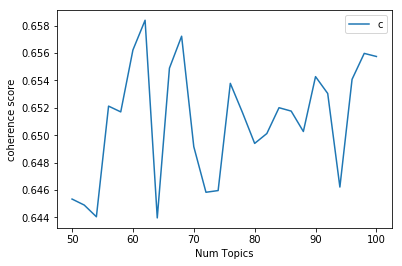

In [8]:
### Ploting coherence values ###

x = range(c.start, c.stop, c.step)
plt.plot(x, cvs_df['coherence'])
plt.xlabel("Num Topics")
plt.ylabel("coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig('{}{}_graph_0_coherence_{}_{}_{}_iter_{}.png'.format(c.directory['save'],
                                                                 c.project_name,
                                                                 c.start,
                                                                 c.stop,
                                                                 c.step,
                                                                 c.LDA_iteration_threshold
                                                                ),
              bbox_inches='tight')
plt.show()